In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append('src/')
from models.gan import MusicGAN
from save_midi import save_notes_and_durations
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name, True)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
len(notes), len(set(notes))

(16050, 310)

In [5]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [6]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [7]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)
    note_targets = np.where(note_targets == 0, -1, note_targets)
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    dur_targets = np.where(dur_targets == 0, -1, dur_targets)
    targets = [note_targets, dur_targets]
    return targets

In [8]:
X = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(15456, 128, 150)

In [9]:
X[1].shape

(15456, 128, 32)

In [10]:
model = MusicGAN(
    n_notes=X[0].shape[-1],
    n_durations=X[1].shape[-1],
    input_dim=X[0].shape[1],
    kernel_size=32,
    discriminator_filters=[64, 64, 64, 64],
    discriminator_strides=[1, 2, 2, 1],
    generator_filters=[64, 64, 64, 64],
    generator_strides=[1, 2, 2, 1],
    z_dim=2,
    learning_rate=0.0005,
    use_batch_norm=True
)

In [11]:
model.discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 150)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 32)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       multiple             0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 multiple             372800      concatenate[0][0]            

In [12]:
model.generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         6144        input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32, 64)       0           dense_1[0][0]                    
__________________________________________________________________________________________________
conv1d_transpose (Conv1DTranspo (None, 32, 64)       131136      reshape[0][0]                    
____________________________________________________________________________________________

In [13]:
model.train(X, 32, 100)

/home/abryl/.cache/pypoetry/virtualenvs/untitled-DiiM6t2A-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (32,128,150) into shape (32,128)

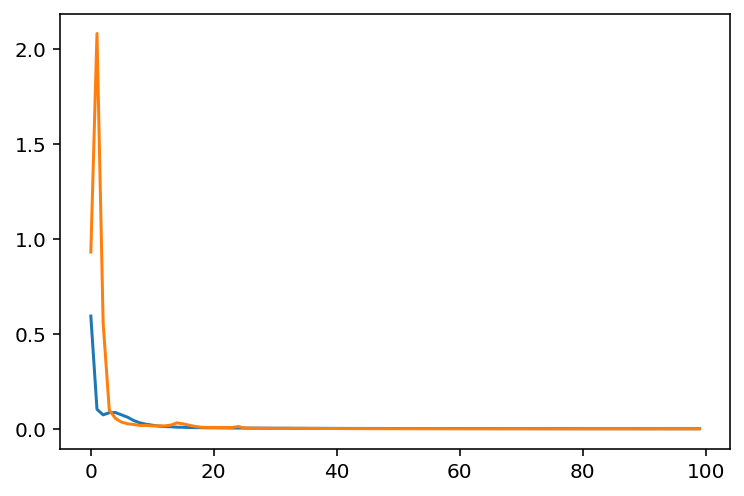

In [14]:
plt.plot(model.c_losses)

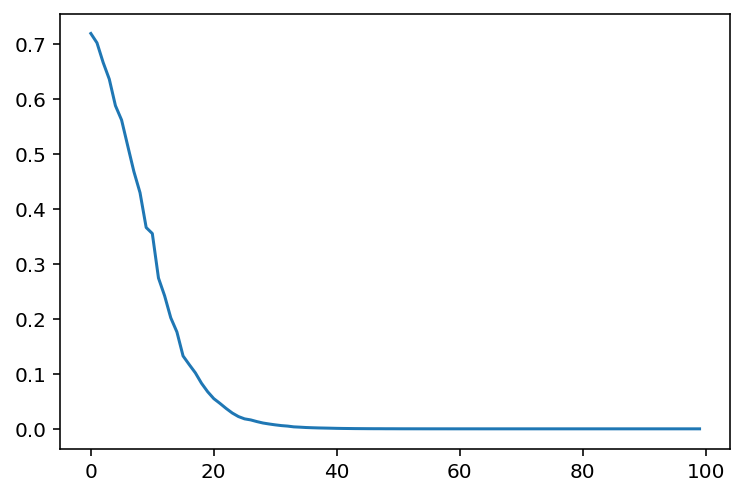

In [15]:
plt.plot(model.g_losses)

In [16]:
for epoch in model.generated.keys():
    if epoch > 0:
        for temperature in [0.0, 0.5, 0.9]:
            samples = [[inv_note_dictionary[x] for x in model.generated[epoch][temperature][0]], [inv_dur_dictionary[x] for x in model.generated[epoch][temperature][1]]]
            save_notes_and_durations(samples, f'output/gan/{epoch}_output_{temperature}_top')